In [1]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import warnings
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
warnings.filterwarnings('ignore')

In [2]:
from osrmareas.osrm import Server
from osrmareas import areas

pbf_file = 'pakistan-latest.osm' #{country, subregion}-latest.osm
pbf_file_path = './countr_pk'

pk_server = Server(pbf_file, pbf_file_path)

# Generate the files
pk_server.gen_osrm_1()
pk_server.prepare_server_2()

# Run the server locally
pk_server.run_server()

from_islamabad = [33.681561, 73.031605]
from_ = from_islamabad.copy()
max_km = 10
grid = 0.5

crs_moll='EPSG:3857'
crs_lat='EPSG:4326'


Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Found ./countr_pk\pakistan-latest.osrm file
Done, generate a osrm file
Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Done, I have generated the local OSRM server with `{server}.run_server()`.
The server is running in the background, you can start making queries.


In [3]:
n = 1  
import os
DIR_NAME = "../output/figures"
def save_plot(name = ""):
    name = name.lower()
    global n  
    num_fig = str(n).zfill(2)
    n += 1  
    file_name = f"{DIR_NAME}/{num_fig}_{name}.png"
    print(file_name)
    plt.savefig(file_name)

files_delete = os.listdir(DIR_NAME)
for file in files_delete:
    path_full = os.path.join(DIR_NAME, file)
    if os.path.isfile(path_full):
        os.remove(path_full)

def save_shp(gdf: gpd.GeoDataFrame,  name: str):
    file_name = f"../output/shapefiles/{name}.shp"
    gdf.to_file(file_name)


def destination(x, y, size_grid):
    coords_pol = [
        (x, y),
        (x + size_grid, y),
        (x + size_grid, y + size_grid),
        (x, y + size_grid),
    ]
    center = size_grid / 2
    coords_center = [x + center, y + center]
    return coords_center
def getFeatures(gdf: gpd.GeoDataFrame):
    import json

    return [json.loads(gdf.to_json())["features"][0]["geometry"]]


def generate_grid(center_lat_long = from_ , radius_km=5, name='', grid_km_size=2.5, show:bool = False):

    n_grid = radius_km / grid_km_size * 2

    center = list(reversed(center_lat_long))
    radius_km = radius_km * 1000
    initial_center = Point(center)

    point_c = gpd.GeoSeries(initial_center, crs=crs_lat).to_crs(crs_moll)
    point_center = point_c.buffer(radius_km, cap_style=3)

    minX, minY, maxX, maxY = point_center.total_bounds
    size_grid_km = (maxY - minY) / n_grid
    cols_grid = list(np.arange(minX, maxX, size_grid_km))
    rows_grid = list(np.arange(minY, maxY, size_grid_km))

    x_destinations = []
    y_destinations = []

    plt.figure(figsize=(6, 6))

    for x in cols_grid:
        for y in rows_grid:
            final = destination(x, y, size_grid_km)
            x_destinations.append(final[0])
            y_destinations.append(final[1])

    print(len(y_destinations))
    if show:
        return(x_destinations, y_destinations)


    ax = plt.gca()
    point_c_moll = point_c.bounds[["minx", "miny"]].T.values

    for i in range(len(cols_grid)):
        plt.axhline(y=rows_grid[i])
        plt.axvline(x=cols_grid[i])

    plt.scatter(point_c_moll[0][0], point_c_moll[1][0], color="red", s=200)

    plt.scatter(x_destinations, y_destinations)
    plt.axis("off")

    ax.set_xlim((minX, maxX))
    ax.set_ylim((minY, maxY))
    save_plot(name)
    # return ax

16
../output/figures/01_grid_5_2.5.png


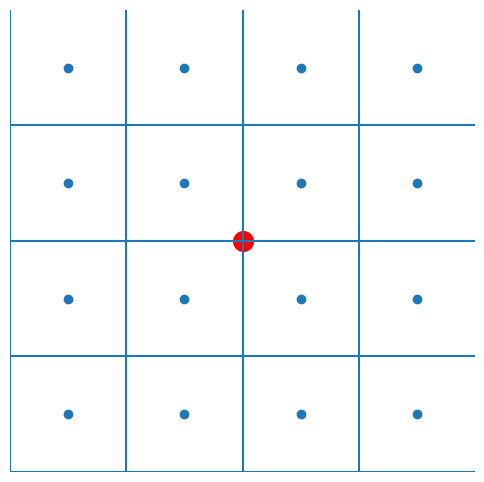

In [4]:
p1 = generate_grid(radius_km=5, grid_km_size=2.5, name='grid_5_2.5')


100
../output/figures/02_grid_5_1.png


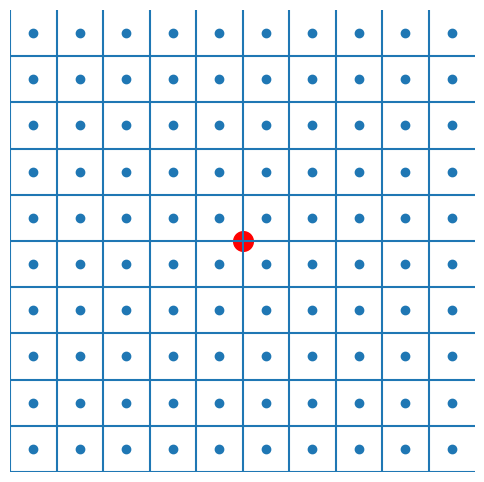

In [5]:
generate_grid(radius_km=5, grid_km_size=1, name='grid_5_1')

400


100%|██████████| 400/400 [00:02<00:00, 157.25it/s]


../output/figures/03_grid_with_routes.png


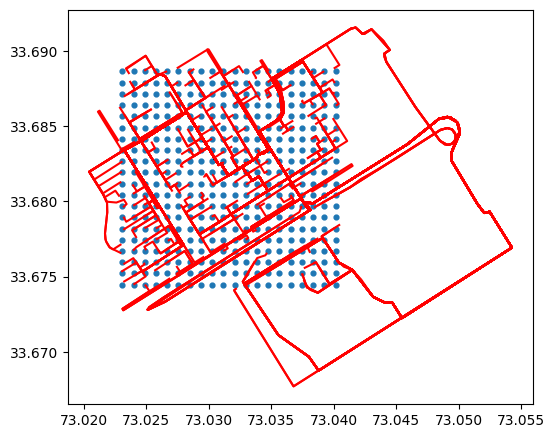

In [6]:
x, y = generate_grid(radius_km=1, grid_km_size=0.1, show=True)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y)).set_crs(crs_moll).to_crs(crs_lat)
x, y = gdf.geometry.x.values, gdf.geometry.y.values
plt.scatter(x, y, s=12)
gdf_area = areas.get_routes(from_, filter_km=False, radius_km=1, grid_km_size=0.1)
gdf_area.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name="Grid_with_routes")

100%|██████████| 400/400 [00:02<00:00, 152.60it/s]


../output/figures/04_grid_with_range_routes.png


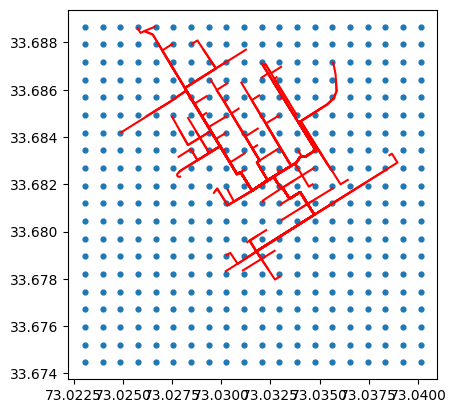

In [7]:
plt.scatter(x, y, s=12)
gdf_area_filter = areas.get_routes(from_, filter_km=True, radius_km=1, grid_km_size=0.1)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name='grid_with_range_routes')

../output/figures/05_grid_with_final_routes.png


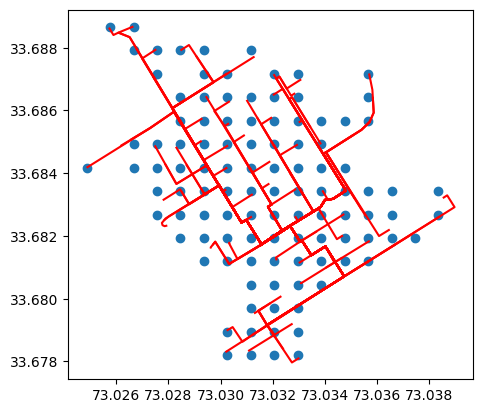

In [8]:
plt.scatter("dest_lat", 'dest_lon', data = gdf_area_filter)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name="grid_with_final_routes")

../output/figures/06_grid_shapefile.png


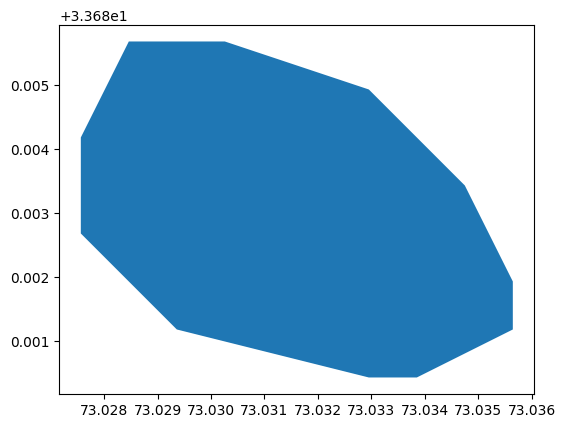

In [9]:
areas.get_ameba(gdf_area_filter).plot()
save_plot("grid_shapefile")

../output/figures/07_shapefile_routes_destination.png


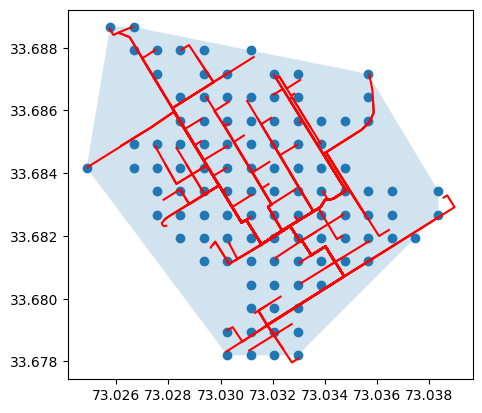

In [10]:
plt.scatter("dest_lat", 'dest_lon', data = gdf_area_filter)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
areas.get_ameba(gdf_area_filter, max_km=1).plot(ax=plt.gca(), alpha = 0.2)
save_plot('shapefile_routes_destination')

In [11]:
from osrmareas import areas

to_ = [33.755963, 72.778764]
rt = areas.get_osrm_route(from_, to_)
rt

,geometry,dist_driving_km,dist_eucl_km,dest_lon,dest_lat,origin_lon,origin_lat
0,"LINESTRING (73.03150 33.68170, 73.03480 33.683...",33.9049,24.845903,33.755963,72.778764,33.681561,73.031605


../output/figures/08_simple_route.png


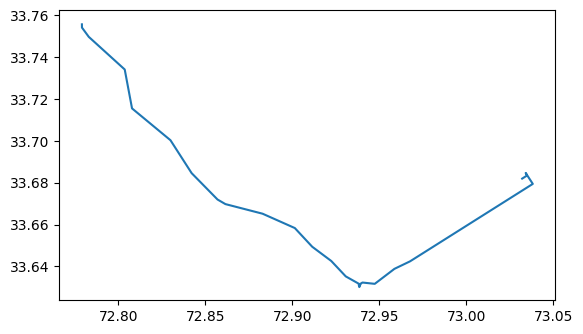

In [12]:
rt.plot()
save_plot("simple_route")

100%|██████████| 16/16 [00:00<00:00, 119.40it/s]


../output/figures/09_routes_5km_2-5km.png


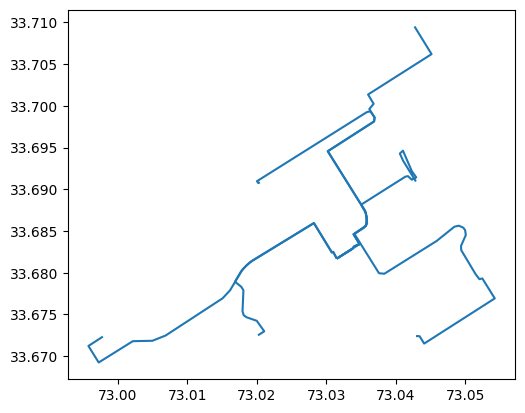

In [13]:
all_rt_1=areas.get_routes(from_, radius_km=5, grid_km_size= 2.5)
all_rt_1.plot()
save_plot("routes_5km_2-5km")

100%|██████████| 100/100 [00:00<00:00, 139.27it/s]


../output/figures/10_routes_5km_1km.png


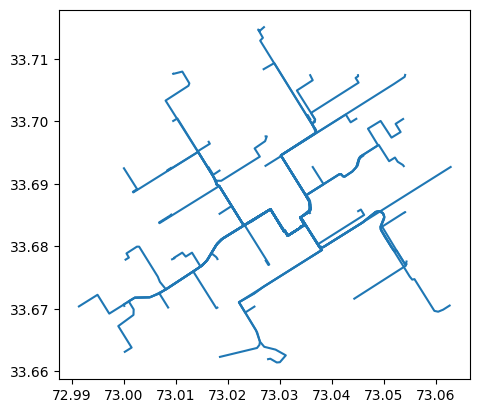

In [14]:
all_rt_2=areas.get_routes(from_, radius_km=5, grid_km_size= 1)
all_rt_2.plot()
save_plot("routes_5km_1km")

100%|██████████| 400/400 [00:02<00:00, 161.27it/s]


../output/figures/11_routes_1km_0-1km.png


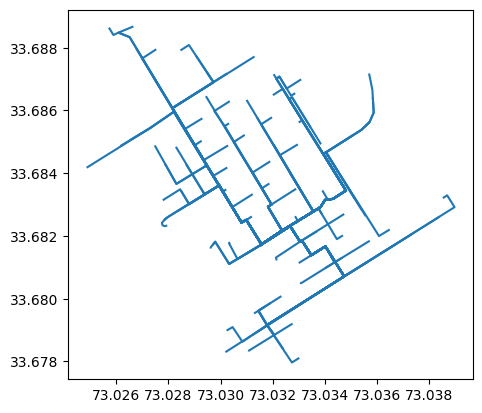

In [15]:
all_rt_3=areas.get_routes(from_, radius_km=1, grid_km_size= 0.1)
all_rt_3.plot()
save_plot(name="routes_1km_0-1km")

100%|██████████| 400/400 [00:03<00:00, 124.27it/s]


../output/figures/12_area_shapefile.png


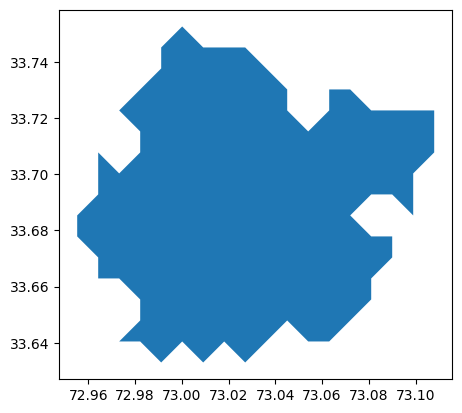

In [16]:
all_rt_3=areas.get_routes(from_, radius_km=max_km, grid_km_size= 1)
ameba = areas.get_ameba(all_rt_3, max_km = max_km, alpha = 150, km_col='dist_driving_km')
ameba.plot()
save_plot("area_shapefile")

In [17]:
isla_ll = [33.681561, 73.031605]
isla_df = areas.get_routes(isla_ll, radius_km=max_km, grid_km_size=grid)
isla_df_shp = areas.get_ameba(isla_df, max_km = max_km, alpha=150)
isla_df.to_file("../output/shapefiles/routes_islamabad.shp")
isla_df_shp.to_file("../output/shapefiles/ameba_islamabad.shp")

100%|██████████| 1600/1600 [00:13<00:00, 119.49it/s]


../output/figures/13_routes_with_package.png


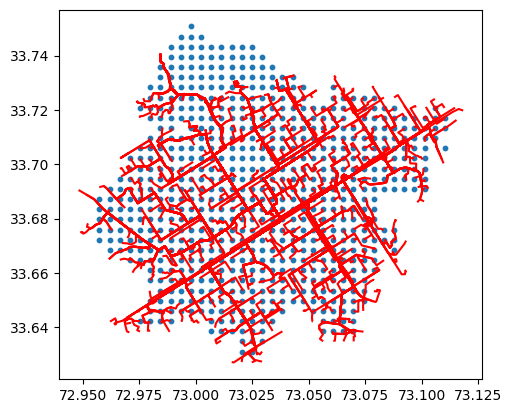

In [18]:
points_df = gpd.GeoDataFrame(isla_df, geometry=gpd.points_from_xy(isla_df["dest_lat"], isla_df["dest_lon"])).set_crs(
    epsg=4326
)
points_inside = gpd.sjoin(points_df, isla_df_shp, how="inner", op="within")
# points_inside
plt.scatter('dest_lat', 'dest_lon', data = points_inside, s=10)
isla_df.plot(ax = plt.gca(), edgecolor='red')
# isla_df
save_plot("routes_with_package")

../output/figures/14_ameba_with_package.png


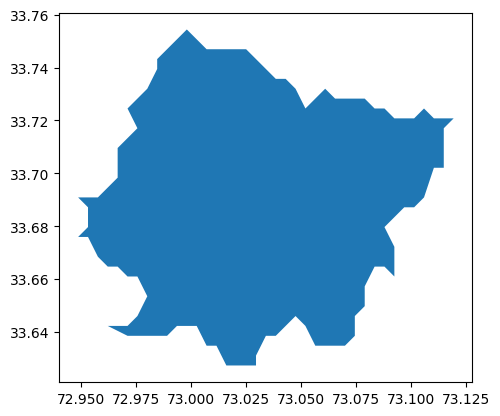

In [19]:
isla_df_shp.plot()
save_plot("ameba_with_package")

../output/figures/15_union_routes_shapefile.png


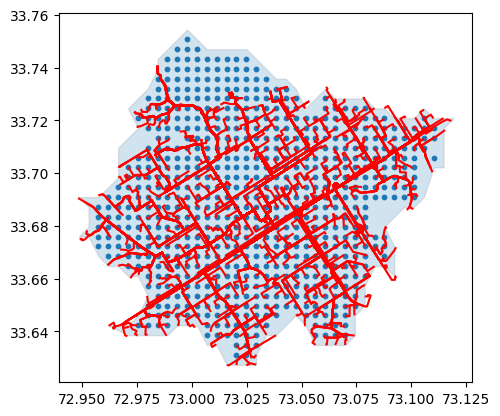

In [20]:
isla_df_shp.plot(ax=plt.gca(), edgecolor='gray', alpha = 0.2, )
plt.scatter('dest_lat', 'dest_lon', data = points_inside, s=10)
isla_df.plot(ax = plt.gca(), edgecolor='red')
save_plot("union_routes_shapefile")

In [21]:
import rasterio as rio
from rasterio.mask import mask
raster_path = (
    "../data/8_night_light/pk_night_light_harm.tiff"  # Path to the raster file
)
shapefile = isla_df_shp  # Shapefile representing the market area

# Crop the raster file using the shapefile
with rio.open(raster_path) as src:
    out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)
values = out_image.flatten()
rows, cols = np.indices(out_image.shape[-2:])
x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

# Create a DataFrame with values and coordinates
data = {"x": x, "y": y, "z": values}
df = pd.DataFrame(data)
df

,x,y,z
0,72.949999,33.758333,-3.400000e+38
1,72.958332,33.758333,-3.400000e+38
2,72.966666,33.758333,-3.400000e+38
3,72.974999,33.758333,-3.400000e+38
4,72.983332,33.758333,-3.400000e+38
...,...,...,...
352,73.083332,33.625000,-3.400000e+38
353,73.091666,33.625000,-3.400000e+38
354,73.099999,33.625000,-3.400000e+38
355,73.108332,33.625000,-3.400000e+38


In [22]:
points_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"])).set_crs(
    epsg=4326
)
points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")
points_inside

,x,y,z,geometry,index_right
27,72.999999,33.750000,14.0,POINT (73.00000 33.75000),0
47,72.991666,33.741667,18.0,POINT (72.99167 33.74167),0
48,72.999999,33.741667,24.0,POINT (73.00000 33.74167),0
49,73.008332,33.741667,30.0,POINT (73.00833 33.74167),0
50,73.016666,33.741667,35.0,POINT (73.01667 33.74167),0
...,...,...,...,...,...
305,73.041666,33.641667,61.0,POINT (73.04167 33.64167),0
307,73.058332,33.641667,62.0,POINT (73.05833 33.64167),0
308,73.066666,33.641667,62.0,POINT (73.06667 33.64167),0
323,73.016666,33.633333,58.0,POINT (73.01667 33.63333),0


../output/figures/16_routes_destinations.png


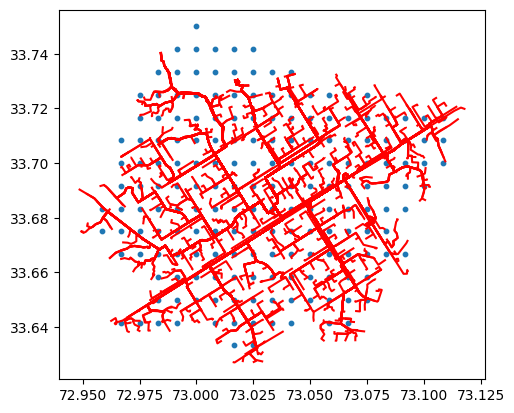

In [23]:
plt.scatter('x', 'y', data = points_inside, s=10)
isla_df.plot(ax = plt.gca(), edgecolor='red')
save_plot("routes_destinations")

In [24]:
import numpy as np

target_name = "nightlight"

# Define the metrics
metrics = [np.mean, np.std, np.sum]
points_result = points_inside.dropna(subset=["z"])
stats = points_result["z"].agg(metrics).values.flatten()

# Assign computed metrics to the shapefile
(
    shapefile[f"{target_name}_mean"],
    shapefile[f"{target_name}_sd"],
    shapefile[f"{target_name}_sum"],
) = stats
shapefile

,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((73.02038 33.74694, 73.02487 33.74694...",55.03825,9.570655,10072.0


In [25]:
def metric_result(
    centroid_from,
    path_raster: str,
    radius_km=4,
    grid_km=1,
    target_name="metrics",
    metrics=[np.mean, np.std, np.sum],
):
    # Generate a shapefile
    routes = areas.get_routes(centroid_from, radius_km=radius_km, grid_km_size=grid_km)
    shapefile = areas.get_ameba(routes, max_km=radius_km)

    # Crop the raster
    with rio.open(path_raster) as src:
        out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)

    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)

    # Points inside
    points_df = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"])
    ).set_crs(epsg=4326)
    points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")

    # Generate Metrics
    points_result = points_inside.dropna(subset=["z"])
    stats = points_result["z"].agg(metrics).values.flatten()

    (
        shapefile[f"{target_name}_mean"],
        shapefile[f"{target_name}_sd"],
        shapefile[f"{target_name}_sum"],
    ) = stats

    return shapefile

In [26]:
centroides_pk = [
    [33.689500, 73.055073],
    [33.748184, 73.176488],
    [33.709539, 73.071614],
    [33.722102, 73.034446],
]

metric_df = gpd.GeoDataFrame()
for centroid in centroides_pk:
    result = metric_result(centroid, path_raster=raster_path)
    metric_df = pd.concat((metric_df, result))
metric_df = metric_df.reset_index().reset_index()

100%|██████████| 64/64 [00:00<00:00, 137.19it/s]


../output/figures/17_multiples_shapefiles.png


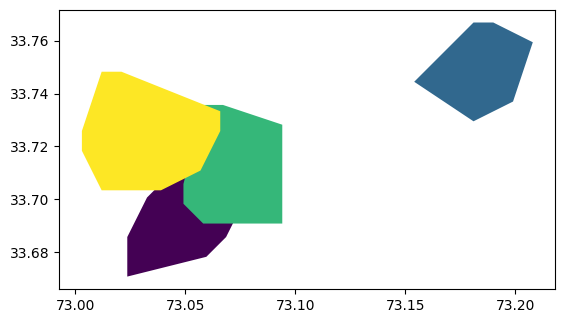

In [27]:
metric_df.plot(column='level_0')
save_plot("multiples_shapefiles")

In [28]:
def metric_df_calculate(centroids, raster_path, **kwargs):
    metric_df = gpd.GeoDataFrame()
    for centroid in centroids:
        result = metric_result(centroid, raster_path, **kwargs)
        metric_df = pd.concat((metric_df, result))
    return metric_df

In [29]:
r_path = "../data/8_night_light/pk_night_light_harm.tiff"
name_col = "nightlight_harm"
metric_df_calculate(centroides_pk, raster_path=r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 144.47it/s]


,geometry,nightlight_harm_mean,nightlight_harm_sd,nightlight_harm_sum
0,"POLYGON ((73.02363 33.67081, 73.02363 33.68576...",60.578949,0.692483,1151.0
0,"POLYGON ((73.18098 33.72951, 73.15403 33.74445...",22.764706,4.548755,387.0
0,"POLYGON ((73.05814 33.69086, 73.04916 33.69833...",61.166668,0.912871,1835.0
0,"POLYGON ((73.01199 33.70342, 73.00300 33.71837...",54.137932,7.179953,1570.0


In [30]:
r_path = '../data/8_night_light/pk_night_light.tiff'
name_col = "nightlight"
metric_df_calculate(centroides_pk, raster_path = r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 148.60it/s]


,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((73.02363 33.67081, 73.02363 33.68576...",20.535206,4.115921,1560.675659
0,"POLYGON ((73.18098 33.72951, 73.15403 33.74445...",3.345394,2.044534,234.177551
0,"POLYGON ((73.05814 33.69086, 73.04916 33.69833...",25.592735,7.647680,2661.644531
0,"POLYGON ((73.01199 33.70342, 73.00300 33.71837...",12.575666,8.437458,1546.807007


In [31]:
pop_tif = "../data/1_density/pak_ppp_2018_1km_Aggregated.tif"
name_col = "population"
metric_df_calculate(centroides_pk, pop_tif, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 148.51it/s]


,geometry,population_mean,population_sd,population_sum
0,"POLYGON ((73.02363 33.67081, 73.02363 33.68576...",4624.154297,552.227966,83234.773438
0,"POLYGON ((73.18098 33.72951, 73.15403 33.74445...",1830.098267,1073.799561,31111.669922
0,"POLYGON ((73.05814 33.69086, 73.04916 33.69833...",4852.949219,627.438843,111617.828125
0,"POLYGON ((73.01199 33.70342, 73.00300 33.71837...",3088.531250,1720.860962,98833.000000


In [32]:
motor_tif = "../data/5_friction_surface/2020_motorized_friction_surface.geotiff"
motor_name = "motor"
metric_df_calculate(centroides_pk, motor_tif, target_name=motor_name)

100%|██████████| 64/64 [00:00<00:00, 143.26it/s]


,geometry,motor_mean,motor_sd,motor_sum
0,"POLYGON ((73.02363 33.67081, 73.02363 33.68576...",0.000813,0.000180,0.015450
0,"POLYGON ((73.18098 33.72951, 73.15403 33.74445...",0.002248,0.005285,0.038209
0,"POLYGON ((73.05814 33.69086, 73.04916 33.69833...",0.000835,0.000178,0.020050
0,"POLYGON ((73.01199 33.70342, 73.00300 33.71837...",0.003071,0.007814,0.098282


In [33]:
srtm_tif = "../data/6_srtm/PK_srtm.tif"
name_col = "altitude"
metric_df_calculate(centroides_pk, srtm_tif, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 149.29it/s]


,geometry,altitude_mean,altitude_sd,altitude_sum
0,"POLYGON ((73.02363 33.67081, 73.02363 33.68576...",536.959839,11.307823,1070161.0
0,"POLYGON ((73.18098 33.72951, 73.15403 33.74445...",604.961487,37.219078,1052633.0
0,"POLYGON ((73.05814 33.69086, 73.04916 33.69833...",558.364014,15.838182,1408194.0
0,"POLYGON ((73.01199 33.70342, 73.00300 33.71837...",624.876587,98.587830,1898375.0


In [34]:
from osrmareas import areas
crd = [33.681561, 73.031605]
islamabad = areas.get_routes(crd, max_km, grid_km_size=grid)
islamabad_area = areas.get_ameba(islamabad, max_km)#.to_file("../sample_data/")

islamabad_area['coord'] = 'islamabad'
islamabad_area = pd.concat((islamabad_area, islamabad_area))
# islamabad_area.to_file("../sample_data/geometries_isla.shp")

pk_ookla = gpd.read_file("../data/9_internet_speed/0_pakistan_okkla.shp")

islamabad_ookla = gpd.sjoin(pk_ookla, isla_df_shp, op='within')

def calculate_metric(df, col, name, metrics = [np.mean, np.std, np.sum]):
    stats = df[col].agg(metrics).values.flatten()
    result = {
        "Name": [name],
        "Mean": [stats[0]],
        "STD": [stats[1]],
        "Sum": [stats[2]]
    }
    result =  pd.DataFrame(result)
    return result

def simple_metric(path_raster, shapefile, name):
    with rio.open(path_raster) as src:
        out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)

    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)

    # Points inside
    points_df = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"])
    ).set_crs(epsg=4326)
    points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")

    # Generate Metrics
    points_result = points_inside.dropna(subset=["z"])
    result = calculate_metric(points_result, 'z', name)

    return result

internet_d = calculate_metric(islamabad_ookla, 'avg_d_kbps', 'Internet Speed (kbps) - Download')
internet_u = calculate_metric(islamabad_ookla, 'avg_u_kbps', 'Internet Speed (kbps) - Upload')
_raster_paths = [
    '../data/8_night_light/pk_night_light_harm.tiff',
    '../data/8_night_light/pk_night_light.tiff',
    '../data/1_density/pak_ppp_2018_1km_Aggregated.tif',
    '../data/5_friction_surface/2020_motorized_friction_surface.geotiff',
    '../data/6_srtm/PK_srtm.tif'
]

_raster_names = [
    "Night Light - Harm"
    ,"Night Light"
    ,"Population 1km"
    ,"Motor Friction"
    ,"Altitude"
]

all_metrics = pd.DataFrame()
for _raster, _names in zip(_raster_paths, _raster_names):
    _result = simple_metric(_raster, islamabad_area, _names)
    all_metrics = pd.concat((_result, all_metrics))
all_metrics = pd.concat((all_metrics, internet_d))
all_metrics = pd.concat((all_metrics, internet_u))
all_metrics.round(5)

100%|██████████| 1600/1600 [00:13<00:00, 120.74it/s]


,Name,Mean,STD,Sum
0,Altitude,572.93140,84.78999,2.572920e+07
0,Motor Friction,0.00214,0.00611,9.611200e-01
0,Population 1km,3523.94336,2067.67407,1.585774e+06
0,Night Light,14.16925,10.20461,2.539130e+04
0,Night Light - Harm,53.47321,11.55975,2.395600e+04
0,Internet Speed (kbps) - Download,11762.21782,6826.94038,3.563952e+06
0,Internet Speed (kbps) - Upload,10628.22442,8009.39946,3.220352e+06


In [35]:
def gen_plot(
    name = '',
    tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif",
    out_raster="../sample_data/out_raster/altitude.tif",
    title_raster="Altitude - Karachi",
    t_label="M.A.S.L",
    map_color_hex=("#6B8FD1", "#2C816B", "#89720A"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
):

    c1, c2, c3 = map_color_hex
    map_color = [(0.0, "white"), (0.1, c1), (0.5, c2), (1.0, c3)]
    cmap_vals = sorted(map_color, key=lambda x: x[0])  # Ordenar cmap_vals en orden ascendente

    gdf = gpd.read_file(shp_sample)

    with rasterio.open(tiff_sample) as src:
        out_image, out_transform = mask(
            src, gdf.geometry, crop=True, nodata=none_data, all_touched=True
        )

        # Obtener la transformación inversa para convertir las coordenadas de píxeles a coordenadas geográficas
        out_meta = src.meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )
        inv_transform = out_transform

    with rasterio.open(out_raster, "w", **out_meta) as dest:
        dest.write(out_image)

    cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

    with rasterio.open(out_raster) as raster:
        data = raster.read(1)
        nodata_value = raster.nodata

        data = np.where(data == nodata_value, np.nan, data)

        # Transformar las coordenadas del raster a coordenadas geográficas
        height, width = data.shape
        xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
        ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff

        plt.figure(figsize=(10, 10))
        plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
        plt.title(title_raster)
        plt.colorbar(label=t_label)

        # Plotear el shapefile
        gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

        save_plot(name)
        
        plt.show()


../output/figures/18_altitude_islamabad.png


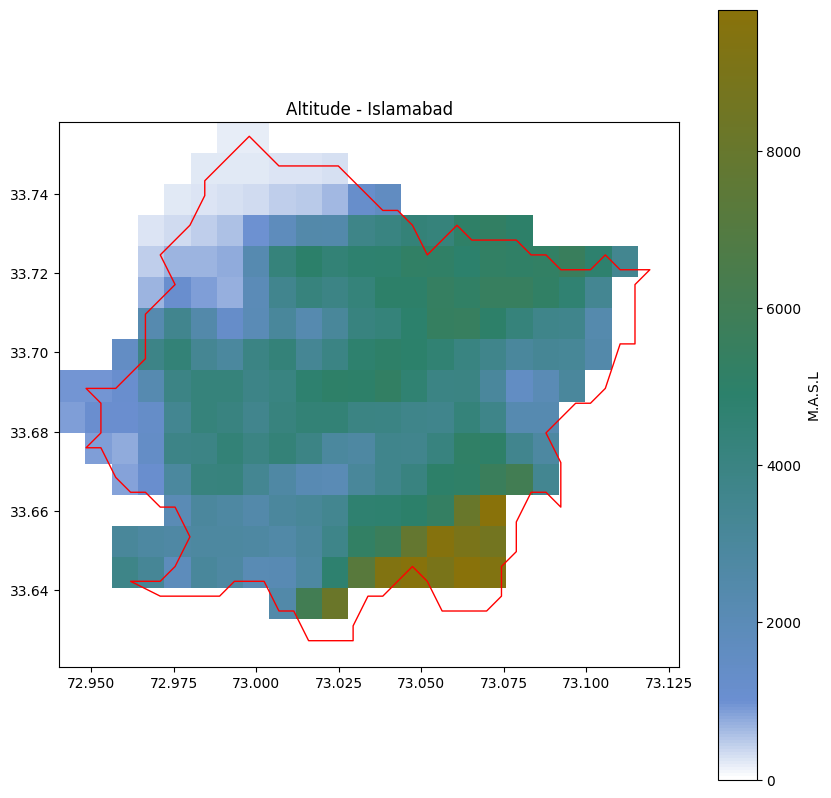

In [36]:
# islamabad
isla_name = "Islamabad"
islamabad_shp = '../output/shapefiles/ameba_islamabad.shp'

gen_plot("altitude_islamabad",shp_sample=islamabad_shp, title_raster=f"Altitude - {isla_name}")

../output/figures/19_friction_surface_islamabad.png


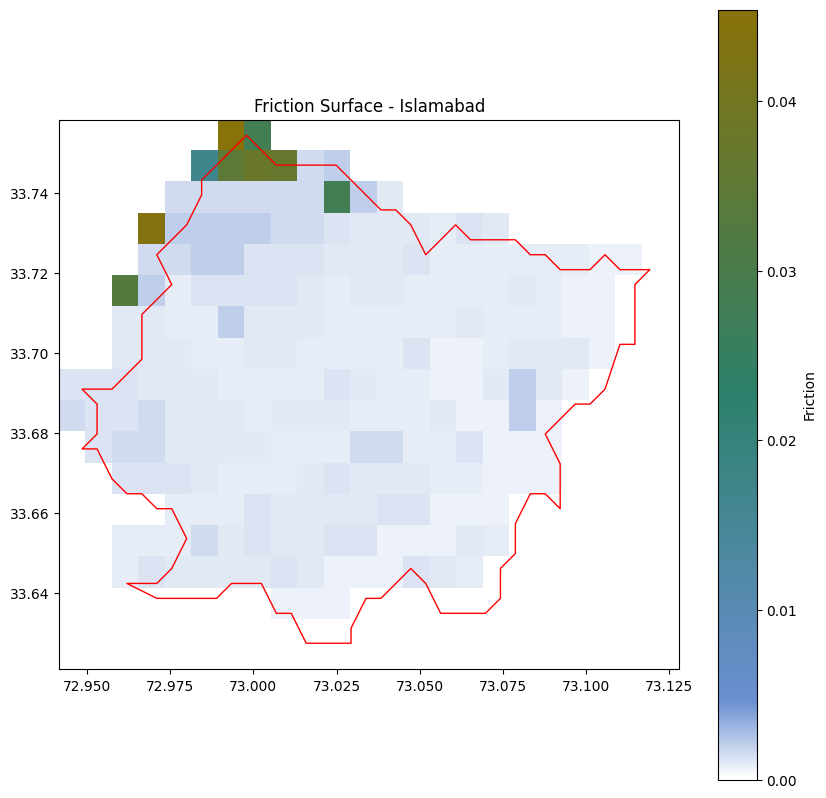

In [37]:
gen_plot(
    "friction_surface_islamabad",
    tiff_sample="../data/5_friction_surface/2020_motorized_friction_surface.geotiff",
    out_raster="../sample_data/out_raster/motor.tif",
    title_raster=f"Friction Surface - {isla_name}",
    t_label="Friction",
    map_color_hex=("#6B8FD1", "#2C816B", "#89720A"),
    none_data=0,
    shp_sample=islamabad_shp
)

../output/figures/20_islamabad_nightlight.png


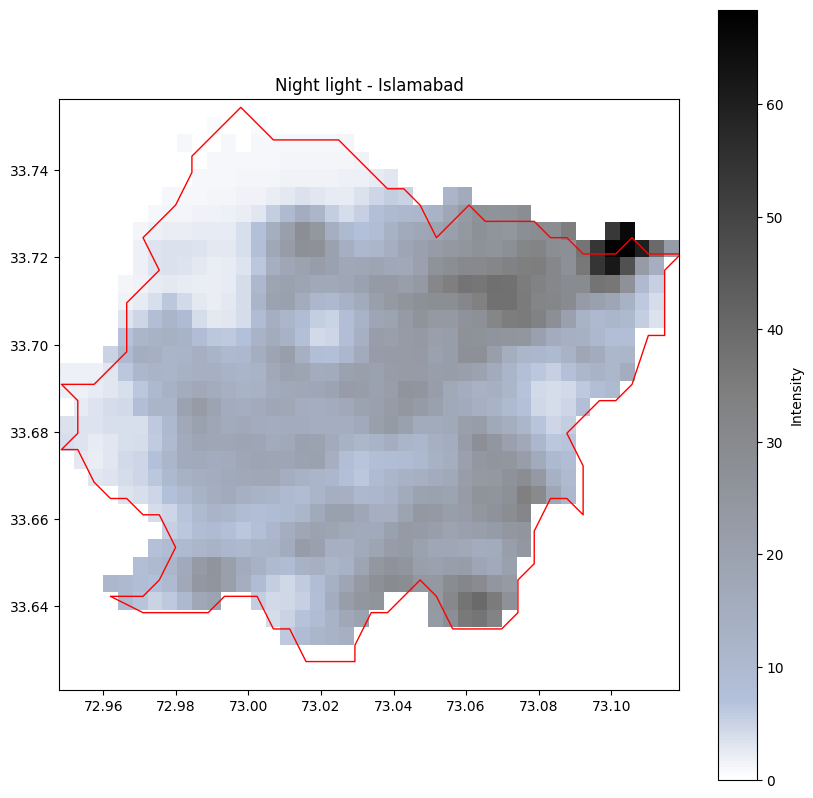

In [38]:
gen_plot(
    "islamabad_nightlight",
    tiff_sample="../data/8_night_light/pk_night_light.tiff",
    out_raster="../sample_data/out_raster/night_light.tif",
    title_raster=f"Night light - {isla_name}",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample=islamabad_shp
)

../output/figures/21_islamabad_nightlight_harm.png


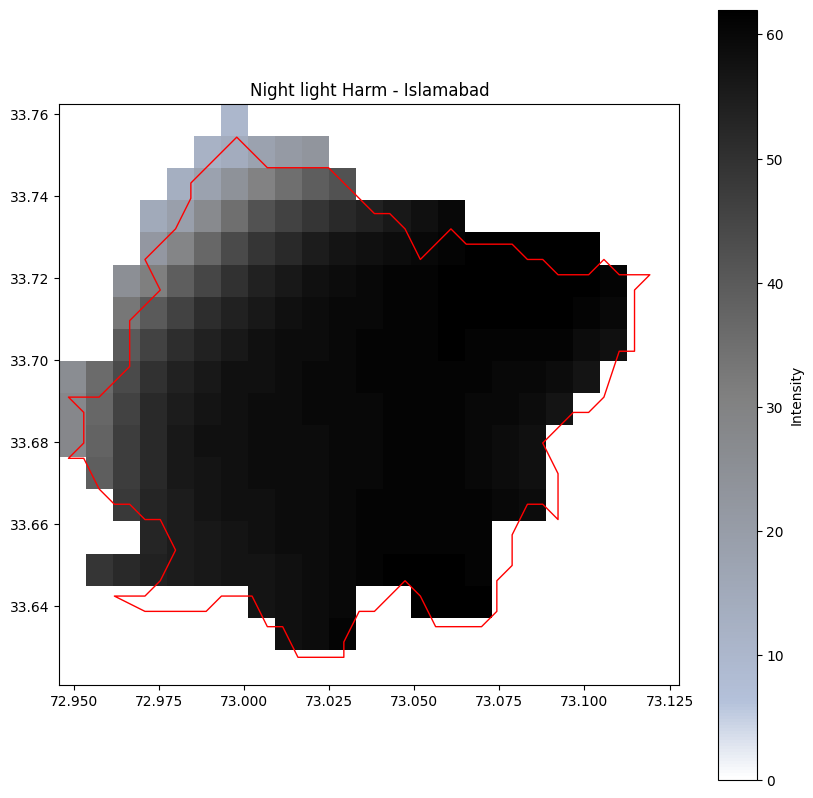

In [39]:
gen_plot(
    "islamabad_nightlight_harm",
    tiff_sample="../data/8_night_light/pk_night_light_harm.tiff",
    out_raster="../sample_data/out_raster/night_light_harm.tif",
    title_raster=f"Night light Harm - {isla_name}",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample=islamabad_shp
)

../output/figures/22_islamabad-population.png


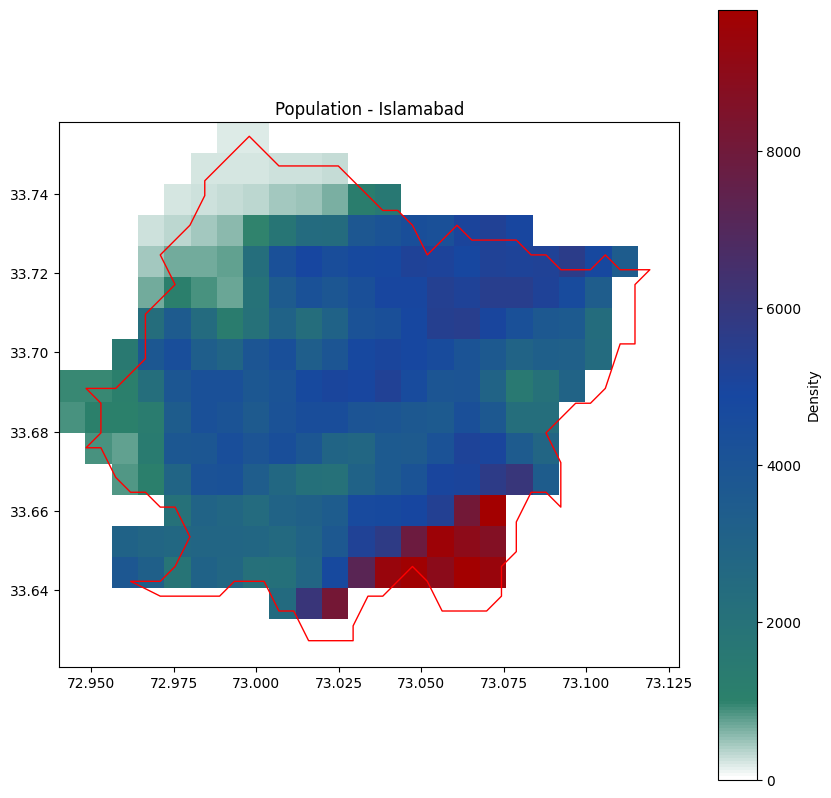

In [40]:
gen_plot(
    "islamabad-population",
    tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif",
    out_raster="../sample_data/out_raster/population.tif",
    title_raster=f"Population - {isla_name}",
    t_label="Density",
    map_color_hex=("#2C816B", "#1747A1", "#A30000"),
    none_data=0,
    shp_sample=islamabad_shp
)

../output/figures/23_islamabad_download_speed.png


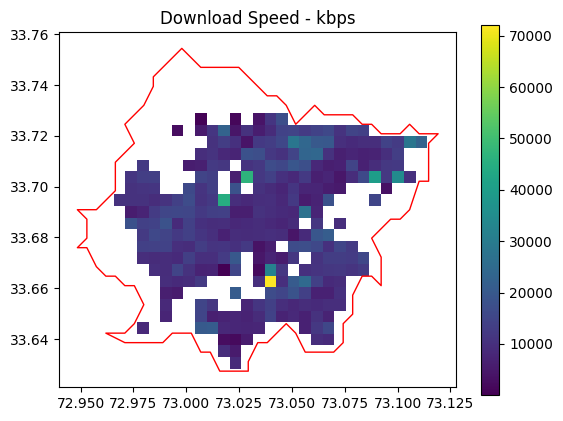

In [41]:
islamabad_ookla.plot(column='avg_d_kbps', legend=True)
isla_df_shp.plot(ax=plt.gca(), edgecolor = 'red', facecolor = 'none')
plt.title("Download Speed - kbps")
save_plot("islamabad_download_speed")

../output/figures/24_islamabad_download_speed.png


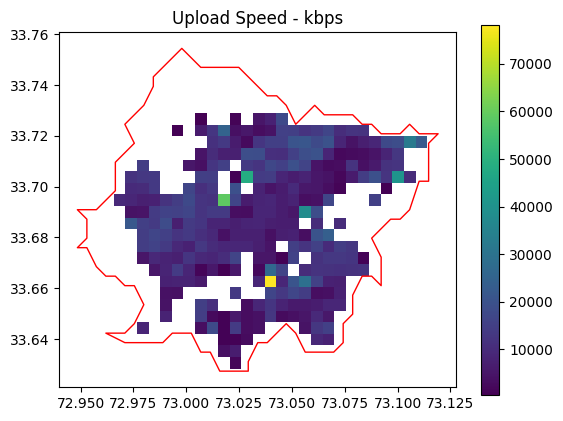

In [42]:
islamabad_ookla.plot(column='avg_u_kbps', legend=True)
isla_df_shp.plot(ax=plt.gca(), edgecolor = 'red', facecolor = 'none')
plt.title("Upload Speed - kbps")
save_plot("islamabad_download_speed")

GHS

In [43]:
labels = {
    1 : "1: MSZ, open spaces, low vegetation surfaces NDVI <= 0.3",
    2 : "2: MSZ, open spaces, medium vegetation surfaces 0.3 < NDVI <=0.5",
    3 : "3: MSZ, open spaces, high vegetation surfaces NDVI > 0.5",
    4 : "4: MSZ, open spaces, water surfaces LAND < 0.5",
    5 : "5: MSZ, open spaces, road surfaces",
    11: "11: MSZ, built spaces, residential, building height <= 3m",
    12: "12: MSZ, built spaces, residential, 3m < building height <= 6m",
    13: "13: MSZ, built spaces, residential, 6m < building height <= 15m",
    14: "14: MSZ, built spaces, residential, 15m < building height <= 30m",
    15: "15: MSZ, built spaces, residential, building height > 30m",
    21: "21: MSZ, built spaces, non-residential, building height <= 3m",
    22: "22: MSZ, built spaces, non-residential, 3m < building height <= 6m",
    23: "23: MSZ, built spaces, non-residential, 6m < building height <= 15m",
    24: "24: MSZ, built spaces, non-residential, 15m < building height <= 30m",
    25: "25: MSZ, built spaces, non-residential, building height > 30m"
}

from matplotlib.colors import LinearSegmentedColormap
def crop_messy_raster(
        raster_path:str, 
        shapefile_path:str, 
        out_raster_file:str, 
        shapefile = None,
        ):
    if shapefile:
        gdf = shapefile
    else:
        gdf = gpd.read_file(shapefile_path)

    with rasterio.open(raster_path) as raster:
        crs_raster = raster.crs.to_dict()
        gdf_raster_proj = gdf.to_crs(crs_raster)
        raster_cropped, transformation = mask(
            raster, gdf_raster_proj.geometry, crop=True
        )

        meta = raster.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": raster_cropped.shape[1],
            "width": raster_cropped.shape[2],
            "transform": transformation,
            "crs": crs_raster 
        })

    with rasterio.open(out_raster_file, "w", **meta) as dest:
        dest.write(raster_cropped)
    return transformation, raster_cropped

def raster_to_data(raster_cropped, transformation):
    values = raster_cropped.flatten()
    rows, cols = np.indices(raster_cropped.shape[-2:])
    x, y = rasterio.transform.xy(transformation, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)
    return df
    

def plot_raster(
    raster_name: str
    , transformation_data
    , original_shp_path = None
    , name_plot = "settlement_islamabad"
    , original_shp = None
    , map_color_hex=(
        "#b2edc2", "#0eb33b", 
        "#102985", 
        "#cfb38f", 
        "#c579d1", "#581363",
        "#c1f4f5", "#038f91"
        )
    , break_points =  [
        0, 0.2,
        0.20, 
        0.3, 
        0.39, 0.66,
        0.70, 1
    ]
):

    if original_shp:
        gdf = original_shp
    else:
        gdf = gpd.read_file(original_shp_path)
    
    map_color = [(bp, col) for bp, col in zip(break_points, map_color_hex)]
    # map_color = [()
        
    #     (0.0, c0), (0.1, c1), (0.5, c2), (1.0, c3)]
    cmap_vals = sorted(map_color, key=lambda x: x[0])  
    # print(map_color)
    cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

    with rasterio.open(raster_name) as raster:
        data = raster.read(1)
        nodata_value = raster.nodata
        crs = raster.crs.to_dict()
        gdf_raster = gdf.to_crs(crs)
        data = np.where(data == nodata_value, np.nan, data)
        height, width = data.shape
        inv_transform = transformation_data
        xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
        ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff
        plt.figure(figsize=(4, 4))
        plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
        # plt.title("Islamabad - Settlement")

        # ################
        # replace = 
        legend_labels = list(labels.values())
        legend_colors = [plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(labels.keys()), vmax=max(labels.keys()))).to_rgba(key) for key in labels.keys()]

        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)], loc='center left', bbox_to_anchor=(1, 0.5))
        # ########### 

        
        gdf_raster.plot(ax=plt.gca(), edgecolor='red', facecolor='none')
        # The line `# plt.colorbar(label='Settlement', ticks=ticks_values)` is a commented-out line of code in the script. If you were to uncomment this line, it would add a colorbar to the plot generated by `plt.imshow(data, cmap=cmap)`.
        # plt.colorbar(label='Settlement')
        save_plot(name_plot)

        plt.show()

def summary_settlement(df: pd.DataFrame, names_settlement  = ['Settlement', "Count", "Percent %"]):
    data_settle = df.query('z > 0 & z < 100').value_counts('z').reset_index().sort_values('z')
    data_settle['percent'] = data_settle['count'] / sum(data_settle['count']) * 100 
    data_settle = data_settle.round(2)
    data_settle['percent'] = data_settle['percent'].astype(str) + " %"
    data_settle.columns = names_settlement
    data_settle[names_settlement[0]] = data_settle[names_settlement[0]].replace(labels)

    return data_settle

In [44]:
settle_raster = '../data/2_setlement/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif'
pk_geometry = "../output/shapefiles/ameba_islamabad.shp"
out_test_raster = '../tutorials/data-pbf/test.tif'

../output/figures/25_latlong_shapefile.png


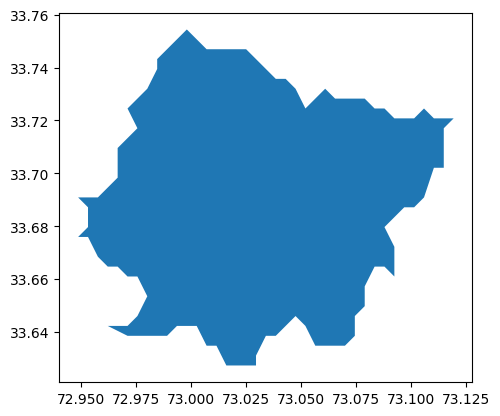

In [45]:
gpd.read_file(pk_geometry).plot()
save_plot("latlong_shapefile")

../output/figures/26_settlement_islamabad.png


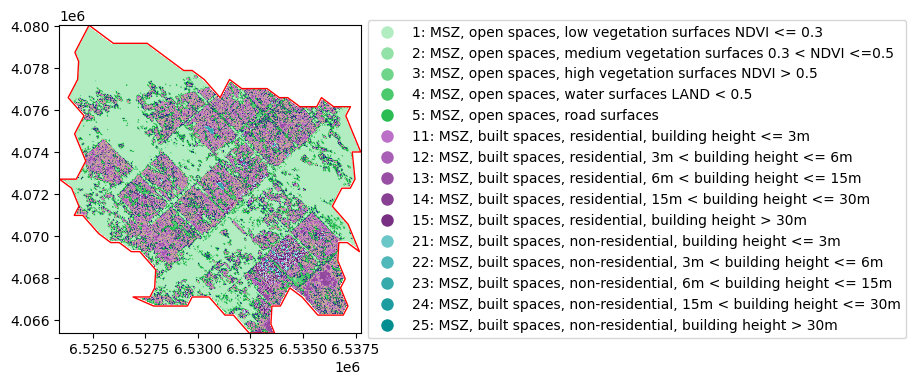

In [46]:
transformation, cropped = crop_messy_raster(settle_raster, pk_geometry, out_test_raster)
plot_raster(out_test_raster, transformation, pk_geometry)

In [47]:
df = raster_to_data(cropped, transformation)
df.head()

,x,y,z
0,6523415.0,4080045.0,255
1,6523425.0,4080045.0,255
2,6523435.0,4080045.0,255
3,6523445.0,4080045.0,255
4,6523455.0,4080045.0,255


In [48]:
pd.set_option('display.max_colwidth', None)
summary = summary_settlement(df)
summary.style.set_properties(**{'text-align': 'left'})

,Settlement,Count,Percent %
3,"1: MSZ, open spaces, low vegetation surfaces NDVI <= 0.3",85173,12.03 %
1,"2: MSZ, open spaces, medium vegetation surfaces 0.3 < NDVI <=0.5",140257,19.8 %
2,"3: MSZ, open spaces, high vegetation surfaces NDVI > 0.5",95392,13.47 %
13,"4: MSZ, open spaces, water surfaces LAND < 0.5",226,0.03 %
7,"5: MSZ, open spaces, road surfaces",18518,2.61 %
6,"11: MSZ, built spaces, residential, building height <= 3m",19094,2.7 %
4,"12: MSZ, built spaces, residential, 3m < building height <= 6m",32928,4.65 %
0,"13: MSZ, built spaces, residential, 6m < building height <= 15m",271400,38.32 %
5,"14: MSZ, built spaces, residential, 15m < building height <= 30m",22626,3.19 %
12,"15: MSZ, built spaces, residential, building height > 30m",267,0.04 %
